In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset ,DataLoader

In [2]:
# ANN (Multi-layer Perceptron)
class AbsDataset(Dataset):
    
    def __init__(self, transform=None):
        xy = np.loadtxt('6Combinations.csv',delimiter=",", dtype=np.float32, skiprows=1)
        self.x = xy[:,:6]
        self.y = xy[:,6:]
        self.n_samples = xy.shape[0]
        
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples

class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
dataset = AbsDataset(transform=ToTensor())
composed = torchvision.transforms.Compose([ToTensor()])
dataset_new = AbsDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data

# hyperparameters
input_size = 6
hidden_size = 400
hidden_size2 = 400
num_classes = 776
num_epochs = 3000
batch_size = 200
learning_rate = 0.001

# Dataset Prep for Training and Testing processes
train_size = int(0.7 * len(dataset_new)) # 70% of the samples for the training set
test_size = len(dataset_new) - train_size # 30% for the test set

# Train_loader (Shuffle) and Test_Loader (No Shuffle)
train_dataset, test_dataset = torch.utils.data.random_split(dataset_new, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, hidden_size2, num_classes)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
    loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)

In [3]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import sklearn.neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import scale
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [4]:
# K Nearest Neighbors
df=pd.read_csv('6Combinations.csv')

# Specifying the X and Y
X_train=pd.DataFrame(next(iter(train_loader))[0].numpy())
Y_train=pd.DataFrame(next(iter(train_loader))[1].numpy())

X_test=pd.DataFrame(next(iter(test_loader))[0].numpy())
Y_test=pd.DataFrame(next(iter(test_loader))[1].numpy())

parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, Y_train)
GridSearchCV(estimator=KNeighborsRegressor(), param_grid={'n_neighbors': range(1, 50),'weights': ['uniform', 'distance']})
test_preds_grid = gridsearch.predict(X_test)

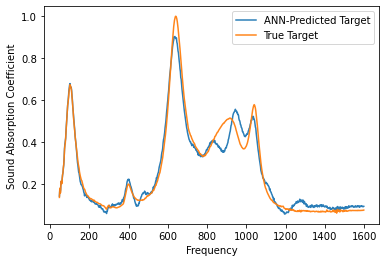

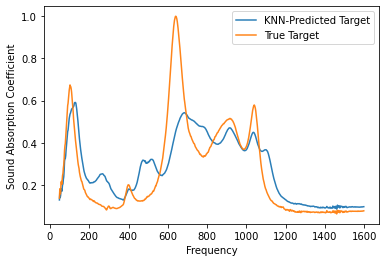

In [11]:
# Comparison between True and Predicted Target Values 
freq_range = range(48,1600,2)
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
torch.no_grad()
outputs = outputs.detach().numpy()

i = 60
plt.plot(freq_range, outputs[i], "-", alpha=14,label="ANN-Predicted Target")
plt.plot(freq_range, labels[i], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend()
plt.show()

plt.plot(freq_range, test_preds_grid[i], "-", alpha=14,label="KNN-Predicted Target")
plt.plot(freq_range, labels[i], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend()
plt.show()

In [13]:
# Regression
labels.tolist()
labels = labels.numpy()

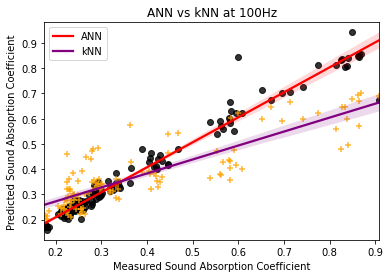

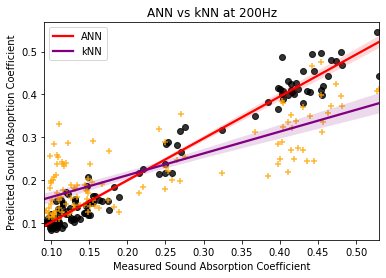

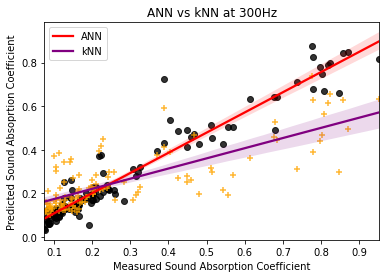

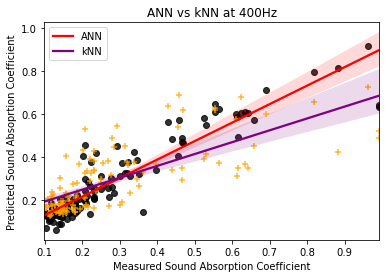

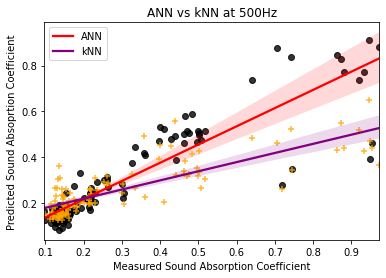

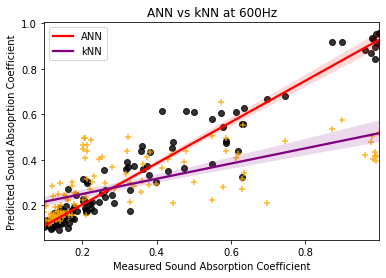

In [16]:
# 100Hz
sns.regplot(x=labels[:,50], y= outputs[:,50], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,50], y=test_preds_grid[:,50], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 100Hz")
plt.show()

# 200Hz
sns.regplot(x=labels[:,100], y= outputs[:,100], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,100], y=test_preds_grid[:,100], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 200Hz")
plt.show()

# 300Hz
sns.regplot(x=labels[:,150], y= outputs[:,150], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,150], y=test_preds_grid[:,150], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 300Hz")
plt.show()

# 400Hz
sns.regplot(x=labels[:,200], y= outputs[:,200], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,200], y=test_preds_grid[:,200], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 400Hz")
plt.show()

# 500Hz
sns.regplot(x=labels[:,250], y= outputs[:,250], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,250], y=test_preds_grid[:,250], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 500Hz")
plt.show()

# 600Hz
sns.regplot(x=labels[:,300], y= outputs[:,300], scatter_kws={"color": "black"}, line_kws={"color": "red"})
sns.regplot(x=labels[:,300], y=test_preds_grid[:,300], scatter_kws={"color": "orange"}, line_kws={"color": "purple"}, marker="+")
plt.legend(labels=["ANN","kNN"])
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN vs kNN at 600Hz")
plt.show()